In [1]:
import os  # Import the os module for interacting with the operating system
os.system('cls')  # Clear the terminal screen 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow info and warning logs, only show errors

import matplotlib.pyplot as plt  # Import matplotlib for plotting images
import numpy as np  # Import numpy for numerical operations
import pandas as pd  # Import pandas for data manipulation
import tensorflow as tf  # Import TensorFlow for deep learning functionalities
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score  # Import metrics for evaluation (not used in this code)
from sklearn.model_selection import train_test_split  # Import train_test_split for dataset splitting (not used in this code)
from tensorflow.keras import layers, losses  # Import necessary layers and loss functions from Keras
from tensorflow.keras.datasets import fashion_mnist  # Import Fashion MNIST dataset from Keras
from tensorflow.keras.models import Model  # Import Keras' Model class to create the autoencoder class

In [23]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset, only the training image data (ignore the labels)
(x_train, _), (_, _) = fashion_mnist.load_data()

# Normalize the training image pixel values to a range of [0, 1]
x_train = x_train.astype('float32') / 255.0

# Read x_test from the space-delimited .txt file
txt_file = "fashion_mnist_test_images.txt"
x_test_flattened = np.loadtxt(txt_file, delimiter=" ")

# Reshape the flattened x_test back to (10000, 28, 28)
x_test = x_test_flattened.reshape(-1, 28, 28)

# Normalize x_test pixel values to a range of [0, 1] if necessary
x_test = x_test.astype('float32') / 255.0

print("x_train shape:", x_train.shape)  
print("x_test shape:", x_test.shape)    


x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


In [24]:

# Define the Autoencoder class that inherits from tf.keras.Model
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    # Initialize the class, latent_dim represents the compressed representation size
    # shape represents the shape of the input data (excluding the batch size)
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    
    # Define the encoder as a sequential model with two layers:
    # 1. Flatten: Flatten the 2D images into a 1D vector
    # 2. Dense: A fully connected layer with 'latent_dim' neurons and ReLU activation
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    
    # Define the decoder as a sequential model with two layers:
    # 1. Dense: Fully connected layer with a number of neurons equal to the total number of pixels in the original image,
    #    and a sigmoid activation function (to output values between 0 and 1)
    # 2. Reshape: Reshape the output back into the shape of the input images
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    # Define the forward pass for the Autoencoder: pass input through encoder and decoder
    encoded = self.encoder(x)  # Compress the input into latent space
    decoded = self.decoder(encoded)  # Reconstruct the input from latent space
    return decoded

# Extract the shape of the test data (excluding batch size)
shape = x_test.shape[1:]
latent_dim = 200  

# Instantiate the Autoencoder model with the given latent dimension and input shape
autoencoder = Autoencoder(latent_dim, shape)

# Compile the Autoencoder model with the Adam optimizer and Mean Squared Error loss function
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Train the autoencoder for 10 epochs, using the training data (x_train) as both input and target
autoencoder.fit(x_train, x_train,
                epochs=10,  # Set the number of training epochs
                shuffle=True,  # Shuffle the training data before each epoch
                validation_data=(x_test, x_test))  # Use test data for validation

# After training, encode the test images into their compressed (latent) representations
encoded_imgs = autoencoder.encoder(x_test).numpy()

# Decode the latent representations back into the reconstructed images
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()




Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0308 - val_loss: 0.0092
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0080 - val_loss: 0.0062
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0039 - val_loss: 0.0041


In [26]:
# Calculate the reconstruction error as the absolute difference between original and reconstructed images
squared_diff = (x_test - decoded_imgs) ** 2
average_abs_diff = np.mean(np.abs(x_test - decoded_imgs), axis=(1, 2), keepdims=True)

reconstruction_error = np.abs(x_test - decoded_imgs) / np.max(x_test - decoded_imgs, axis=(1, 2), keepdims=True)
reconstruction_MSE = (squared_diff / average_abs_diff) / np.max(squared_diff / average_abs_diff, axis=(1, 2), keepdims=True)


# Print the shape 
print("x_test Shape:", x_test.shape)
print("decoded_imgs Shape:", decoded_imgs.shape)
print("reconstruction_error Shape:", reconstruction_error.shape)
print("reconstruction_MSE Shape:", reconstruction_MSE.shape)


x_test Shape: (10000, 28, 28)
decoded_imgs Shape: (10000, 28, 28)
reconstruction_error Shape: (10000, 28, 28)
reconstruction_MSE Shape: (10000, 28, 28)


First image index = 0


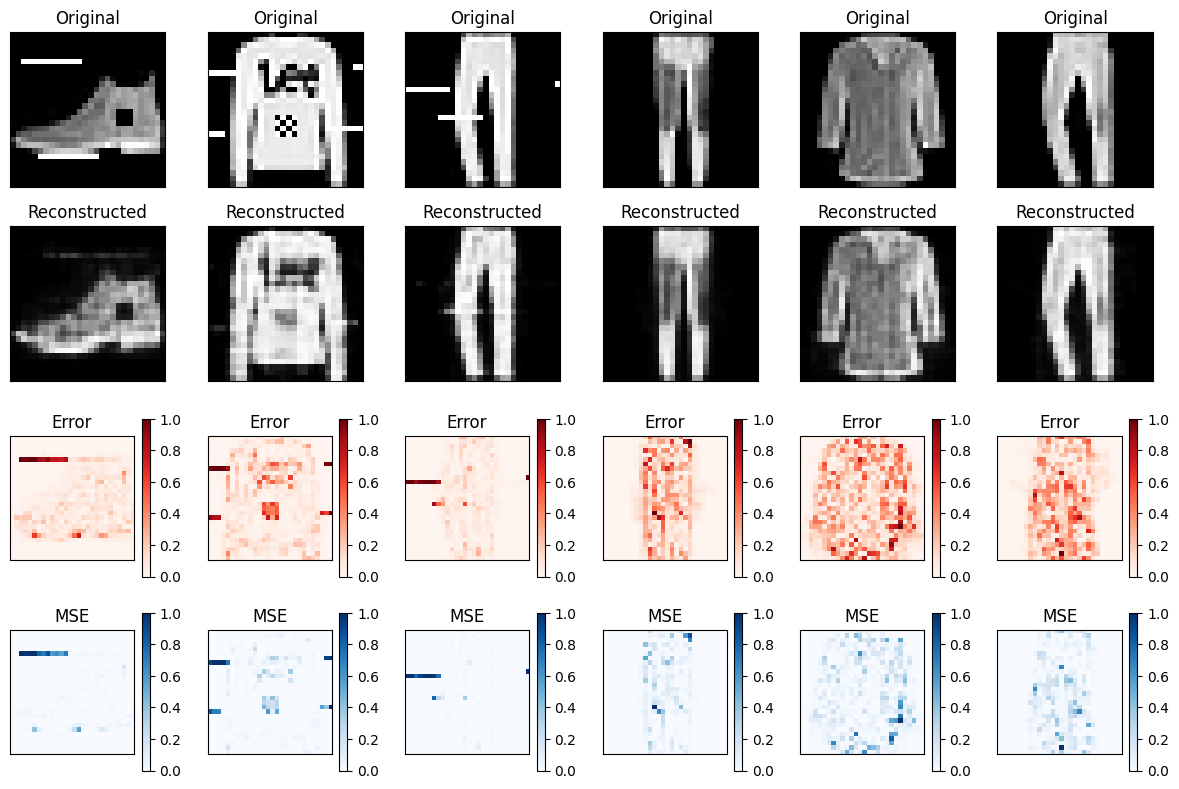

In [28]:
### Visualization

n=6

# Generate a random starting index
start_index = 0 #random.randint(n, len(x_test) - n)
print ("First image index =",start_index)
# Display the original, reconstructed images, reconstruction error, and reconstruction MSE for comparison
plt.figure(figsize=(2 * n, 8))  # Adjust the figure size to fit four rows

for i in range(n):
    idx = start_index + i  # Adjust the index for plotting

    # Display original images
    ax = plt.subplot(4, n, i + 1)  # First row for original images
    plt.imshow(x_test[idx])  # Display the original test image
    plt.title("Original")  # Add a title to the subplot
    plt.gray()  # Display the image in grayscale
    ax.get_xaxis().set_visible(False)  # Hide x-axis labels
    ax.get_yaxis().set_visible(False)  # Hide y-axis labels

    # Display the reconstructed images
    ax = plt.subplot(4, n, i + 1 + n)  # Second row for reconstructed images
    plt.imshow(decoded_imgs[idx])  # Display the reconstructed image
    plt.title("Reconstructed")  # Add a title to the subplot
    plt.gray()  # Display the image in grayscale
    ax.get_xaxis().set_visible(False)  # Hide x-axis labels
    ax.get_yaxis().set_visible(False)  # Hide y-axis labels

    # Display the reconstruction error
    ax = plt.subplot(4, n, i + 1 + 2 * n)  # Third row for reconstruction error
    im = plt.imshow(reconstruction_error[idx], cmap='Reds', vmin=0, vmax=1)  # 
    plt.title("Error")  # Add a title to the subplot
    plt.colorbar(im, ax=ax)  # Add a colorbar for better interpretation
    ax.get_xaxis().set_visible(False)  # Hide x-axis labels
    ax.get_yaxis().set_visible(False)  # Hide y-axis labels

    # Display the reconstruction MSE
    ax = plt.subplot(4, n, i + 1 + 3 * n)  # Fourth row for reconstruction MSE
    im = plt.imshow(reconstruction_MSE[idx], cmap='Blues', vmin=0, vmax=1)
    plt.title("MSE")  # Add a title to the subplot
    plt.colorbar(im, ax=ax)  # Add a colorbar for better interpretation
    ax.get_xaxis().set_visible(False)  # Hide x-axis labels
    ax.get_yaxis().set_visible(False)  # Hide y-axis labels


# Show the final plot
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()
